# Projet : Détection de fraude par chèque (classification dans un contexte déséquilibré)
---------------------

## I. Introduction du sujet, présentation des données d'études

### I.1 La fraude par chèque



La fraude par chèque fait référence à tout moyen visant à obtenir de l'argent illégalement à l'aide de chèques papier ou numériques. Cela peut inclure une personne écrivant un chèque sans provision sur son propre compte, falsifiant un chèque au nom de quelqu'un d'autre ou élaborant un chèque complètement faux. Il existe de nombreuses autres moyens de fraude par chèque (check kiting, chèque flottant, vol de chèque, altération chimique, fraude par mandat-poste ...)

Ici, notre étude va porter sur la détection de fraude par chèque dans un contexte déséquilibré. En effet, nous disposons d'un jeu de données contenant très peu de transactions frauduleuses par rapport au nombre total de transactions.





### I.2 Données d'étude

Ces transactions sont issues d'une enseigne de la grande distribution ainsi que de certains organismes bancaires (FNCI et Banque de France). Elles ont été effectuées par chèque dans un magasin de l'enseigne quelque part en France durant l'année 2017, du 01/02 au 30/11 (soit au total 10 mois de transactions). 

Le jeu de données est composé de **4 646 773** transactions dont seulement **29 995 frauduleuses**, soit **0.64%** du total.  
<br/>

<u>*Reprise du sujet*</u> :  
Le jeu de données comporte 23 variables dont certaines sont issues du feature engineering : 


* **ZIBZIN** : identiﬁant relatif à la personne, i.e. il s’agit de son identiﬁant bancaire (relatif au chéquier en cours d’utilisation)  
* **IDAvisAutorisAtionCheque** : identiﬁant de la transaction en cours

* **Montant** : montant de la transaction

* **DateTransaction** : date de la transaction

* **CodeDecision** : il s’agit d’une variable qui peut prendre ici 4 valeurs
    - 0 : la transaction a été acceptée par le magasin
    - 1 : la transaction et donc le client fait partie d’une liste blanche (bons payeurs). Vous
n’en rencontrerez pas dans cette base de données
    - 2 : le client fait d’une partie d’une liste noire, son historique indique cet un mauvais payer (des impayés en cours ou des incidents bancaires en cours), sa transaction est alors automatiquement refusée
    - 3 : client ayant était arrêté par le système par le passé pour une raison plus ou moins fondée

* **VériﬁanceCPT1** : nombre de transactions eﬀectuées par le même identiﬁant bancaire au cours du même jour
* **VériﬁanceCPT2** : nombre de transactions eﬀectuées par le même identiﬁant bancaire au cours des trois derniers jours
* **VériﬁanceCPT3** : nombre de transactions eﬀectuées par le même identiﬁant bancaire au cours des sept derniers jours

* **D2CB** : durée de connaissance du client (par son identiﬁant bancaire), en jours. Pour des contraintes légales, cette durée de connaissance ne peut excéder deux ans

* **ScoringFP1** : score d’anormalité du panier relatif à une première famille de produits (ex : denrées alimentaires)
* **ScoringFP2** : score d’anormalité du panier relatif à une deuxième famille de produits (ex : électroniques)
* **ScoringFP3** : score d’anormalité du panier relatif à une troisième famille de produits (ex : autres)

* **TauxImpNb_RB** : taux impayés enregistrés selon la région où a lieu la transaction
* **TauxImpNB_CPM** : taux d’impayés relatif au magasin où a lieu la transaction

* **EcartNumCheq** : diﬀérence entre les numéros de chèques

* **NbrMagasin3J** : nombre de magasins diﬀérents fréquentés les 3 derniers jours

* **DiﬀDateTr1** : écart (en jours) à la précédente transaction
* **DiﬀDateTr2** : écart (en jours) à l’avant dernière transaction
* **DiﬀDateTr3** : écart (en jours) à l’antépénultième transaction

* **CA3TRetMtt** : montant des dernières transactions + montant de la transaction en cours
* **CA3TR** : montant des trois dernières transactions
* **Heure** : heure de la transaction

* <span style="color:red"> **FlagImpaye** </span> : variable cible à prédire. Acception (0) ou refus de la transaction (1) car considérée comme frauduleuse.

### I.3 Importation des librairies et des données

#### Librairies utilisées



In [ ]:
# Si execution sur serveur colab 

!pip install "dask[complete]"  
!pip install pandas==1.3.4 # Ne peut pas charger les pickles si version = 1.1.5
!pip install dask_ml
!pip install distributed==2.4.0

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy.random import seed

import pickle
import sys
import datetime as dt
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as ddf
from dask import delayed
from dask_ml.preprocessing import StandardScaler, DummyEncoder
from dask_ml.compose import ColumnTransformer

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,precision_score,recall_score, make_scorer,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve,plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV as sklearn_GridSearchCV, cross_val_score, train_test_split
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTENC

In [ ]:
%matplotlib inline
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

seed(1)
import tensorflow
tensorflow.random.set_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

#### Fonctions crées


In [ ]:
# Fonction pour faire la normalisation et le onehot encoding

def preprocessing(XTrain,scale="y",onehot="n"):

    numerical_features = XTrain.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = XTrain.select_dtypes(include=['category']).columns

    # Standardisation
    numerical_pipeline = Pipeline([('scaler',StandardScaler())])

    # Codage disjonctif
    categorical_pipeline = Pipeline([('onehot',DummyEncoder(drop_first=True))]) 

    if ((scale =="y") and (onehot=="y")):
      preprocessor = ColumnTransformer(
          transformers = [
              ('num',numerical_pipeline,numerical_features),
              ('cat',categorical_pipeline,categorical_features)
          ],n_jobs=-1
      )
    elif  ((scale =="y") and (onehot=="n")):
      preprocessor = ColumnTransformer(
          transformers =[
              ('num',numerical_pipeline,numerical_features)
          ],
          remainder='passthrough',
          n_jobs=-1
      )
    elif ((scale =="n") and (onehot=="y")):
      preprocessor = ColumnTransformer(transformers =[('cat',categorical_pipeline,categorical_features)],remainder='passthrough',n_jobs=-1)
          
    return preprocessor


In [ ]:
# Création d'une fonction pour afficher la matrice de confusion avec le f1 score 
def plot_confusion_matrix(yTest,y_pred,title):
    cm = confusion_matrix(yTest, y_pred,labels=[1,0])
    cm_df = pd.DataFrame(cm,
                         index = ['Refus', 'Acceptation'],
                         columns = ['Refus', 'Acceptation'])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
    plt.title(title + '\nf1_score:{0:.3f}'.format(f1_score(yTest, y_pred,average='binary')))
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()

#### Chargement des données

Nous avons choisi d'utiliser la librairie *dask* afin d'éviter de dépasser les capacités de la RAM de nos machines. Cette librairie découpe les données en plusieurs dataframes pandas et nous permet d’ y appliquer des algorithmes de machine learning assez facilement. 

Chemin depuis Google Drive pour exécution sur serveur colab : 

In [ ]:
from google.colab import drive
MOUNTPOINT = '/content/drive'
DATADIR = os.path.join(MOUNTPOINT,'MyDrive','Colab Notebooks/Projet Fouille de données')
drive.mount(MOUNTPOINT)
os.chdir(DATADIR)

Mounted at /content/drive


Chemin pour une execution en local : 




In [ ]:
# Pour une exécution en local sur colab (le cpu de la machine distante est uniquement composé de 2 coeurs...) : connect to local runtime
# Anaconda prompt : jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8889 --NotebookApp.port_retries=0

In [ ]:
# Romain

#os.chdir(r"C:\Users\Romain\Documents\GitHub\M2_Fraud_detection")
os.chdir(r"C:\Users\rodud\Documents\GitHub\M2_Fraud_detection")

In [ ]:
# Franck

os.chdir(r"C:\Users\doron\Documents\M2 SISE\Fouille de données")

Sur les 22 variables explicatives nous avons : 
- 20 quantitatives
- une date : DateTransaction
- une catégorielle : CodeDecision (que l'on considère dans un premier temps comme numérique)


In [ ]:
data = ddf.read_csv("guillaume.txt", sep=';',dtype={
       'CA3TRetMtt': 'float64',
       'CA3TR': 'float64',
       'CodeDecision': 'int64',
       'D2CB': 'int64',
       'DiffDateTr1': 'float64',
       'DiffDateTr2': 'float64',
       'DiffDateTr3': 'float64',
       'EcartNumCheq': 'int64',
       'FlagImpaye': 'int64',
       'Heure': 'int64',
       'Montant': 'float64',
       'NbrMagasin3J': 'int64',
       'ScoringFP1': 'float64',
       'ScoringFP2': 'float64',
       'ScoringFP3': 'float64',
       'TauxImpNB_CPM': 'float64',
       'TauxImpNb_RB': 'float64',
       'VerifianceCPT1': 'int64',
       'VerifianceCPT2': 'int64',
       'VerifianceCPT3': 'int64'}, header=0, assume_missing=True, parse_dates=['DateTransaction'],decimal=",",blocksize=30*1024*1024)

#Transformation de la colonne DateTransaction pour ne garder seulement que la date et enlever l'heure
data['DateTransaction'] = ddf.to_datetime(data['DateTransaction']).dt.date
data['DateTransaction'] = data['DateTransaction'].astype('datetime64')

# blocksize=963*1024*1024
# Choix optimal du blocksize ?

In [ ]:
# Aperçu du format dask
data

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
npartitions=32,,,,,,,,,,,,,,,,,,,,,,,
,object,float64,int64,float64,datetime64[ns],int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## II. Exploration des données et pré-traitements

### II.1 1er aperçu

In [ ]:
# Premières lignes
data.head()

Wall time: 937 ms


,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044.0,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045.0,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046.0,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047.0,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048.0,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [ ]:
# Comptage des modalités de la variable cible
Count_FlagImpaye = Counter(data['FlagImpaye'])
print(Count_FlagImpaye)

Counter({0: 4616778, 1: 29995})


In [ ]:
# Pourcentage de fraude
(Count_FlagImpaye[1]/Count_FlagImpaye[0]) * 100

0.6496955235880955

Nous avons 29 995 cas de fraude dans l'ensemble du jeu de données, soit 0.65 % des transactions.

### II.2 Analyse de la variable "CodeDecison" : 

Regardons de plus près cette variable catégorielle :

In [ ]:
# Comptage des modalités de la variable CodeDecision
count = Counter(data['CodeDecision'])
Count_CodeDecision = count.most_common()
Count_CodeDecision

[(0, 3502786), (1, 1121626), (2, 19562), (3, 2798), (4, 1)]

Les valeurs que prend cette variable diffèrent de la description originale des données :  

En effet, on note la présence : 
- de transactions dont le client fait partie d'une liste blanche (1 121 626 transactions)

- d'une seule transaction dont la variable CodeDecision est égale à 4, ce qui ne correspond à une aucune des modalités connues de la variable. Nous pouvons considérer qu'il s'agit d'une erreur et supprimer cette transaction.

In [ ]:
# Aperçu de la ligne dont CodeDecsion = 4
data[data.CodeDecision == 4].compute()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
10043,A013010041908018598931129,83408970.0,0,14.63,2017-09-14,4,0,0,0,1,...,45.368313,52.076034,0,1,5.0,5.0,5.0,14.63,0.0,62770


In [ ]:
# suppression de la modalité 4 de CodeDecision
data = data[data.CodeDecision != 4]

# reconversion de CodeDecision en type category
data = data.astype(
    {
       'CA3TRetMtt': 'float64',
       'CA3TR': 'float64',
       'CodeDecision': 'category',
       'D2CB': 'int64',
       'DiffDateTr1': 'float64',
       'DiffDateTr2': 'float64',
       'DiffDateTr3': 'float64',
       'EcartNumCheq': 'int64',
       'FlagImpaye': 'int64',
       'Heure': 'int64',
       'Montant': 'float64',
       'NbrMagasin3J': 'int64',
       'ScoringFP1': 'float64',
       'ScoringFP2': 'float64',
       'ScoringFP3': 'float64',
       'TauxImpNB_CPM': 'float64',
       'TauxImpNb_RB': 'float64',
       'VerifianceCPT1': 'int64',
       'VerifianceCPT2': 'int64',
       'VerifianceCPT3': 'int64'}
)

# spécificité de dask pour les catégories : category[unknown]	-> category[known]
data = data.categorize(columns=['CodeDecision'])

In [ ]:
# Transactions frauduleuses
fraud_data = data[data['FlagImpaye']==1]

In [ ]:
# Répartion des fraudes suivant les modalités de CodeDecision
crosstab = pd.crosstab(fraud_data["FlagImpaye"],fraud_data['CodeDecision'],rownames=['FlagImpaye'], colnames=['CodeDecision'],normalize='index').round(4)*100
crosstab

CodeDecision,0,1,2,3
FlagImpaye,,,,
1,33.06,0.94,62.87,3.13


<AxesSubplot:xlabel='FlagImpaye'>

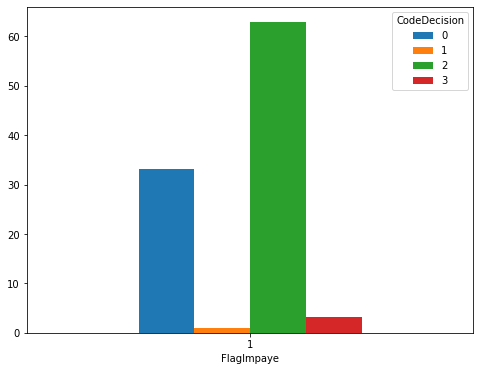

In [ ]:
crosstab.plot.bar(rot=0)

On constate que parmis les transactions considérées comme frauduleuses, plus de 60% des payeurs font partie d'une liste noire. 

Dans seulement 3 % des transactions frauduleuses, le client à été arreté par le système par le passé. 

On note également de 30 % des transactions considérées comme frauduleuses ont été acceptée. (Or d'après l'énoncé, les transactions frauduleuses sont refusées$, incohérence avec l'énoncé ?)

### II.3 Matrice des corrélations

<AxesSubplot:>

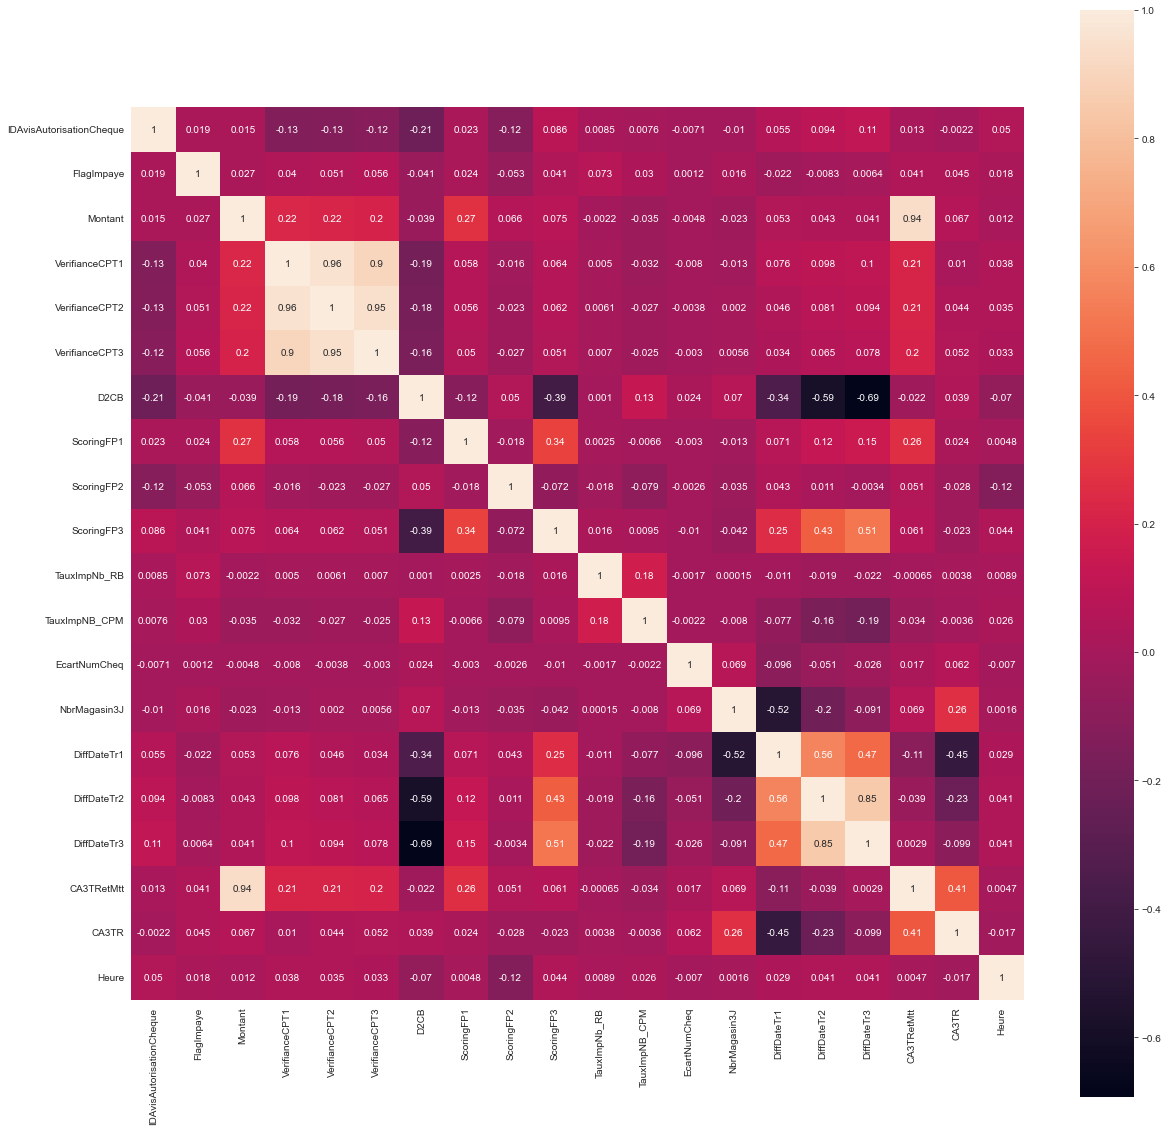

In [ ]:
sns.set_style("darkgrid")
pyplot.figure(figsize=(20, 20))

sns.heatmap(data = data.compute().corr(), square=True, annot=True, xticklabels=True, yticklabels=True)

On remarque qu'aucune des variables n'est corrélée linéairement à la variable cible

## III. Séparation apprentissage / test  et pré-traitements



Compte tenu de la description des variables, nous n'allons pas toutes les utiliser pour faire nos prédictions. 

On excluera naturellement les variables "ZIBZIN", "IDAvisAutorisationCheque", "DateTransaction" et"Heure" : 


Les deux premières correspondent à des identifiants qui ne vont pas aider dans l'apprentissage.  

Concernant la date de la transaction, celle-ci ne peut pas être prise telle quelle pour faire nos prédictions (à moins de la recoder), mais nous avons choisi de ne pas la prendre tenir compte.   

Enfin nous avons jugé inutile de garder l'heure à laquelle à eu lieu la transaction. 


In [ ]:
#Filtrage des colonnes à garder
ColsToRemove = ["ZIBZIN","IDAvisAutorisationCheque","DateTransaction","FlagImpaye","Heure"]
ColsToKeep = [col for col in data.columns if col not in ColsToRemove]

In [ ]:
#Création DataFrame apprentissage
XTrain = data[data['DateTransaction'] < '2017-09-01'][ColsToKeep]
yTrain = data[data['DateTransaction'] < '2017-09-01']["FlagImpaye"]

#Création DataFrame Test
XTest = data[data['DateTransaction'] >= "2017-09-01"][ColsToKeep]
yTest = data[data['DateTransaction'] >= "2017-09-01"]["FlagImpaye"]

On va procéder à la normalisation des variables numériques et au codage disjonctif des variables catégorielles. 

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC

In [ ]:
#selector2 = RFECV(LogisticRegression(random_state = 0,max_iter=5000),step=1,min_features_to_select=2,cv=5)

In [ ]:
#selector2.fit(Xtrain_scaled,yTrain)

RFECV(cv=5, estimator=LogisticRegression(max_iter=5000, random_state=0),
      min_features_to_select=2)

In [ ]:
#selector2.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

D'après le RFE l'ensembles des variables doit être conservé. Supprimmer une seule variable altère la qualité du modèle(ici la régression logistique)

## IV. Machine learning avec méthodes de ré-échantillonnage. 

Pour rappel la variable à prédire est la variable FlagImpaye, qui est une variable binaire :  

* 0 la transaction est acceptée et considérée comme "normale", 
* 1 la transaction est refusée car considérée comme "frauduleuse".

Plusieurs critères peuvent être utilisées pour évaluer la performance d’un modèle comme l’Accuracy, la précision, le rappel, la F-mesure ou encore l’aire sous la courbe ROC (AUC ROC). 

Dans le cas présent, nous chercherons à établir le modèle nous permettant d’obtenir les meilleurs résultats en classiﬁcation en maximisant la F-mesure, dont la formule est :  $2\frac{précision \cdot rappel}{précision + rappel}$ = $\frac{2TP}{2TP+FN+FP}$
<br/>
<br/>

En présence de données déséquilibrées, les phases d'apprentissage et de prédiction des algorithmes de machine learning peuvent être affectées. En effet, la fonction de décision de ces algorithmes favorisera la classe avec le plus grand nombre d'échantillons, c'est à dire la classe majoritaire. 

Une façon de lutter contre ce problème est d'utiliser des critères de performances adaptés au déséquilibre ainsi que des méthodes de ré-échantillonnage des données afin de mieux équilibrer la distribution des classes et ainsi aider les algorithmes à mieux détecter la classe minoritaire (dans notre cas les transactions frauduleuses). 

Pour ce faire, il existe des méthodes de : 
- sur-échantillonnage (oversampling) consistant à créer de nouvelles observations de la classe minoritaire.
- sous-échantillonnage (undersampling) consistant à supprimer des observations de la classe majoritaire.
- combinaison d'oversampling et d'undersampling.

Nous utiliserons les librairies : 
- *imbalenced learn* pour les méthodes de ré-échantillonnage
- *scikit-learn* pour les algorithmes de classification 

### IV.1 Démarche expérimentale

Afin de prédire les fraudes nous ferons appel à des méthodes d'apprentissage supervisées et non supervisées.  

Nous nous limiterons aux méthodes suivantes : 

<u>Méthodes supervisées : </u>
- Random Forest
- Gradient Boosting
- Analyse discriminante linéaire
- Régression logistique 


<u>Méthodes non supervisées : </u> 
- Kmeans
- Isolation Forest
- Autoencoder

Pour chacune des méthodes supervisées, nous testerons 3 méthodes de ré-échantillonage : 
- Oversampling : Random oversampling et Smote 
- Undersamplling : Random undersampling

La méthode expérimentale se déroulera de la manière suivante et sera identique pour tous les algorithmes testés:


*   Application de notre fonction de preprocess qui standardise le jeu et applique un codage disjonctif sur la variable catégorielle.
*   Détermination des meilleurs paramètres par le biais d'un Gridsearch avec les méthodes de ré-échantillonnage
*   Entrainement du modèle et calcul des prédictions et probabilités d'affectation aux modalités de la variable cible sur l'échantillon de test
*   Affichage des matrices de confusion
*   Calcul de l'ensembles des métriques(f1 score,auc)
*   Enregistrement des métriques pour comparaison des modèles dans la dernière partie
*   Affichage de la courbe ROC







### IV.2 Méthodes de ré-echantillonnage utilisées

Pour chaque modèle supervisé, nous avons d’abord utilisé des méthodes de ré-échantillonnage aléatoire qui est la stratégie la plus simple et la plus naïve : 
- Random Oversampling (RandomOverSampler): des transactions sont dupliquées au hasard dans la classe majoritaire.
- Random Undersampling (RandomUnderSampler): des transactions sont supprimées au hasard dans la classe minoritaire.  

Les deux approches peuvent être répétées jusqu'à ce que la distribution de classe souhaitée soit atteinte dans l'ensemble de données d'apprentissage, comme une répartition égale entre les classes.  

Nous avons également utilisé SMOTE (Synthetic Minority Over-sampling Technique), une autre méthode d’oversampling qui synthétise de nouveaux échantillons par interpolation en se basant sur les K plus proches voisins d’une instance de la classe minoritaire. Par défaut nous avons gardé k = 5. En réalité nous avons utilisé une variante de SMOTE : SMOTENC qui prend en compte le fait que des variables puissent être catégorielle (pour la variable CodeDecision).  

Nous avons également voulu tester Adasyn qui est une méthode d’oversampling similaire à SMOTE mais celui-ci prenait trop de temps à exécuter et nous ne l’avons pas utilisé pour tous nos modèles, d’autant plus qu’il ne permet pas de prendre en compte les variables catégorielles.  

De plus, étant donné que nous avons beaucoup d’observations, nous n’avons pas volontairement générée où supprimer suffisamment de transactions pour nous ramener à une situation d’équilibre parfait. Nous avons fait nos test en jouant sur le paramètre « sampling_strategy » = 0.1 ou 0.2. C’est dire en générant ou supprimant autant de transactions de telle sorte que le ratio entre le nombre de transaction frauduleuses et le nombre de transactions soit égal à 0.1 ou 0.2. 


### IV.3 Méthodes supervisées

#### IV.3.1 Random Forest

Random Forest est un algorithme de Bagging. L'algorithme des forêts d'arbres effectue un apprentissage en parallèle sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents obtenues par bootstraping. Le nombre idéal d’arbres, qui peut aller jusqu’à plusieurs centaines est un paramètre important.  
 
Nous avons gardé les paramètres par défaut de scikit-learn. Ainsi nos différents modèles de random forest seront constitués de 100 arbres de décision et l’impureté de Gini pour fractionner les arbres de décisions.


In [ ]:
# création d'un dataframe qui contiendra les résultats de nos meilleurs modèles pour les comparer à la fin
GraphFrame = pd.DataFrame(columns={'modele', 'sampling', 'auc', 'fscore'})

##### IV.3.1.1 Random Forest sans ré-échantillonage

In [ ]:
# F1 score de la cross validation avec les paramètres par défaut et sans prétraitements

%%time 
tscv = TimeSeriesSplit(5)
print(cross_val_score(RandomForestClassifier(n_jobs=-1), XTrain.compute(), yTrain.compute(), scoring = make_scorer(f1_score),cv=tscv).mean())

0.8296824473565778
Wall time: 14min 12s


On obtient un f1 score moyen assez élévé en cross validation. 

###### 1er essai sans prétraitements

In [ ]:
%%time
clf = RandomForestClassifier(random_state=42,n_jobs=-1)
clf.fit(XTrain, yTrain)
yPred = clf.predict(XTest)

Wall time: 6min 58s


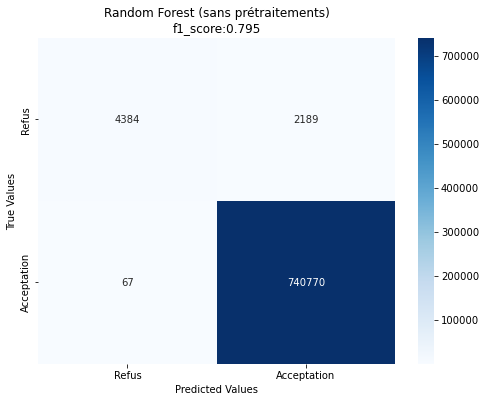

Wall time: 2min 21s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred,"Random Forest (sans prétraitements)")

In [ ]:
Counter(yTest)

Counter({0: 740837, 1: 6573})

On obtient un f1-score de 0.795, ce qui est plutôt bon. 

TP = 4384 fraudes ont été correctement prédites / 6573  
TN = 740 770 transactions normales correctement prédites / 740 837  
FP = 67 transactions normales ont été prédites comme frauduleuses.  
FN = 2189 transactions frauduleuse ont été prédites comme normales.

F Mesure = $\frac{2TP}{2TP+FN+FP}$ 
= 2(4384) /(2(4384) + 2189 + 67) = 8768/11024 = 0.795

###### 2ème essai avec prétraitements (normalisation + codage disjonctif)

In [ ]:
prep = preprocessing(XTrain,scale="y",onehot="y")
pipelineRF = Pipeline([('prep',prep),('RF', RandomForestClassifier(random_state=42,n_jobs=-1))])

In [ ]:
%%time
pipelineRF.fit(XTrain, yTrain)
yPred2 = pipelineRF.predict(XTest)

Wall time: 7min 1s


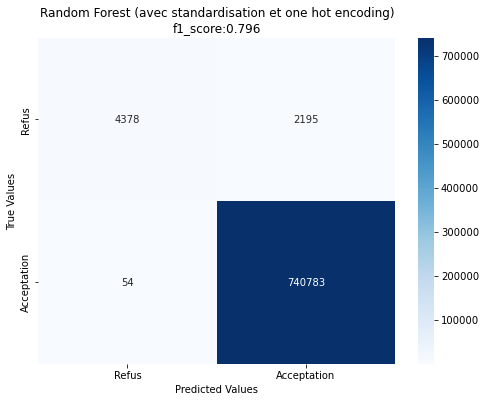

Wall time: 2min 24s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred2,"Random Forest (avec standardisation et one hot encoding)")

On obtient un f1 score de 0.796, ce qui est à peine meilleure que sans pré-traitements.

In [ ]:
#Calcul des prédictions
yPredScore = clf.predict_proba(XTest)
prob = yPredScore[:, 1]
fper1, tper1, thresholds1 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'Random Forest', 'sampling':'none', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

##### IV.3.1.2 Random Forest avec ré-échantillonage

###### RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
%%time 

rus = RandomUnderSampler(random_state=42)
pipelineRF = imbPipeline([('rus', rus),('rf', RandomForestClassifier(random_state=42,n_jobs=-1))])
paramsRF = {
    'rus__sampling_strategy':[0.1,0.2],
}

tscv = TimeSeriesSplit(5)
gridsearchRF = sklearn_GridSearchCV(estimator=pipelineRF,param_grid=paramsRF,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchRF.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchRF.best_estimator_.predict(XTest)

print(gridsearchRF.best_params_)
print(gridsearchRF.best_score_)

{'rus__sampling_strategy': 0.1}
0.6391773745638891
Wall time: 1min 36s


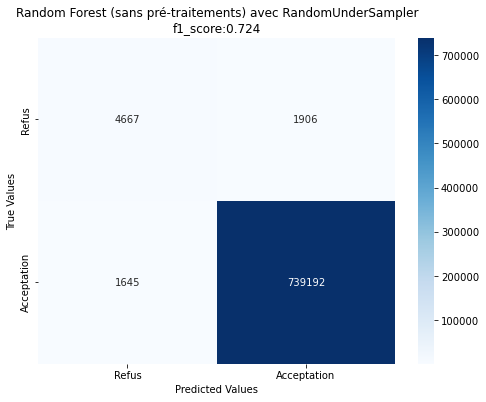

In [ ]:
plot_confusion_matrix(yTest,yPred,"Random Forest (sans pré-traitements) avec RandomUnderSampler")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchRF.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper2, tper2, thresholds2 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'Random Forest', 'sampling':'RUS', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

Pas d'amélioration significative de la f mesure 

###### RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
%%time 

ros = RandomOverSampler(random_state=42)
pipelineRF = imbPipeline([('ros', ros),('rf', RandomForestClassifier(random_state=42,n_jobs=-1))])
paramsRF = {
    'ros__sampling_strategy':[0.1,0.2],
}

tscv = TimeSeriesSplit(5)
gridsearchRF = sklearn_GridSearchCV(estimator=pipelineRF,param_grid=paramsRF,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchRF.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchRF.best_estimator_.predict(XTest)

print(gridsearchRF.best_params_)
print(gridsearchRF.best_score_)

{'ros__sampling_strategy': 0.1}
0.8260858726655493
Wall time: 31min 23s


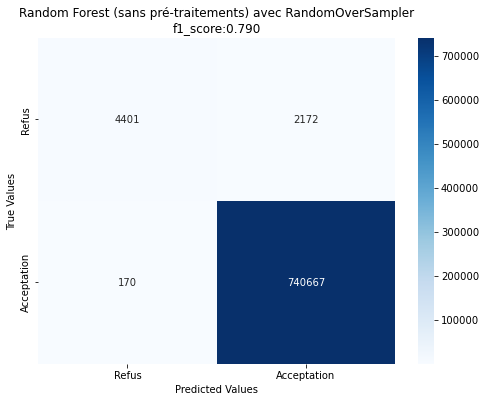

In [ ]:
plot_confusion_matrix(yTest,yPred,"Random Forest (sans pré-traitements) avec RandomOverSampler")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchRF.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper3, tper2, thresholds2 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'Random Forest', 'sampling':'ROS', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

###### SMOTENC

On va utiliser la variante SMOTENC de SMOTE pour qu'il puisse gérer la variable catégorielle *CodeDecision*.

In [ ]:
from sklearn.model_selection import GridSearchCV as sklearn_GridSearchCV
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time 
smotenc = SMOTENC(categorical_features=[17],n_jobs=-1,random_state=42)
pipelineRF = imbPipeline(
    [('prep1',preprocessing(XTrain,scale="y",onehot="n")),
     ('smotenc', smotenc),
     ('prep2',preprocessing(XTrain,scale="n",onehot="y")),
     ('RF', RandomForestClassifier(random_state=42,n_jobs=-1))])

paramsRF = {
    'smotenc__sampling_strategy':[0.1,0.2],
}

tscv = TimeSeriesSplit(5)
gridsearchRF = sklearn_GridSearchCV(estimator=pipelineRF,param_grid=paramsRF,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchRF.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchRF.best_estimator_.predict(XTest)

Wall time: 35min 11s


In [ ]:
gridsearchRF.best_params_

{'smotenc__sampling_strategy': 0.1}

In [ ]:
gridsearchRF.best_score_

0.8005568427749699

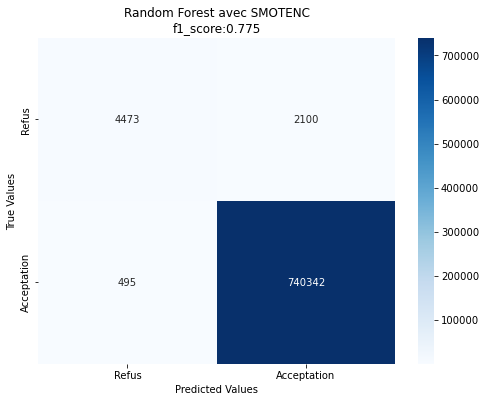

In [ ]:
plot_confusion_matrix(yTest,yPred,"Random Forest avec SMOTENC")

Nous obtenons un f1 score de 0.775, ce qui est moins que sans ré-échantillonage. 

Il ne semble donc pas intéressant de tester SMOTENC avec une valeur plus élevée du paramètre *sampling_strategy*.  

Il aurait été toutefois interessant de faire plusieurs tests avec un random state différent mais les temps de calculs étant assez long nous ne pouvons pas tout tester.

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchRF.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper4, tper4, thresholds4 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'Random Forest', 'sampling':'SMOTENC', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
GraphFrame

,sampling,fscore,modele,auc
0,none,0.795356,Random Forest,0.903020
1,RUS,0.724408,Random Forest,0.931885
2,ROS,0.789842,Random Forest,0.905601
3,SMOTENC,0.775149,Random Forest,0.919038


In [ ]:
# Sauvegarde des résultats de la RF
#with open('score_RF', 'wb') as f1:
#    pickle.dump(GraphFrame, f1)

###### Adasyn

Adasyn de imblearn ne permet pas de traiter correctement les variables catégorielles, regardons tout de même : 

In [ ]:
from imblearn.over_sampling import ADASYN 

In [ ]:
%%time
# 1er test sans prétraitements
ada01 = ADASYN(random_state=42,sampling_strategy=0.1,n_jobs=-1)
XTrain_Adasyn, yTrain_Adasyn = ada01.fit_resample(XTrain,yTrain)

# Cela prend énormément de temps pour un petit sampling_strategy sans pré-traitement. 
# Adasyn ne semble pas viable sans standardisation  

Wall time: 44min 23s


In [ ]:
# Sauvegarde

#with open('XTrain_Adasyn01_no_prep', 'wb') as f1:
#    pickle.dump(XTrain_Adasyn, f1)
    
#with open('yTrain_Adasyn01_no_prep', 'wb') as f2:
#    pickle.dump(yTrain_Adasyn, f2)

In [ ]:
%%time
clf = RandomForestClassifier(random_state=42,n_jobs=-1)
fit_clf = clf.fit(np.nan_to_num(XTrain_Adasyn.astype(np.float32)), yTrain_Adasyn)
yPred = fit_clf.predict(XTest)

# Nécessite un traitement particulier -> sinon "Input contains NaN, infinity or a value too large for dtype('float32')."

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Wall time: 7min 26s


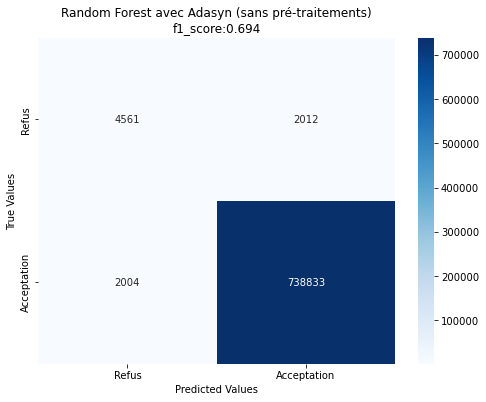

In [ ]:
plot_confusion_matrix(yTest,yPred,"Random Forest avec Adasyn (sans pré-traitements)") 

In [ ]:
%%time
# 2ème test avec prétraitements
prep = preprocessing(XTrain,scale="y",onehot="y")
ada01 = ADASYN(random_state=42,sampling_strategy=0.1,n_jobs=-1)
XTrain_Adasyn, yTrain_Adasyn = ada01.fit_resample(prep.fit_transform(XTrain),yTrain)  

Wall time: 41min 37s


In [ ]:
# Sauvegarde

#with open('XTrain_Adasyn01_prep', 'wb') as f1:
#    pickle.dump(XTrain_Adasyn, f1)
    
#with open('yTrain_Adasyn01_prep', 'wb') as f2:
#    pickle.dump(yTrain_Adasyn, f2)

In [ ]:
%%time
fit_clf = clf.fit(XTrain_Adasyn, yTrain_Adasyn)
yPred = fit_clf.predict(prep.fit_transform(XTest))

Wall time: 7min 35s


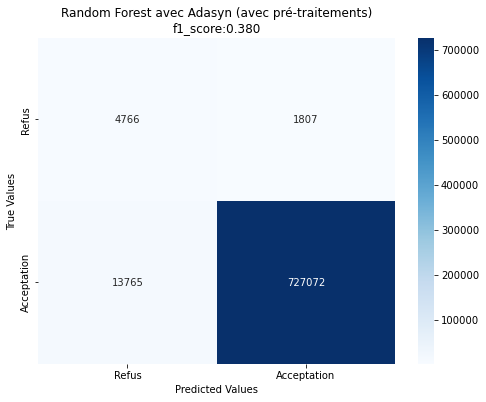

In [ ]:
plot_confusion_matrix(yTest,yPred,"Random Forest avec Adasyn (avec pré-traitements)") 

Conclusion des différents tests : Bien que nous n'ayons pas pas fait de cross validation, il semblerait que les méthodes de ré-échantillonage couplé avec le random forest ne donnent un meilleure f mesure. Le random forest appliqué seul sur les données non pré-traitées à donné le meilleur resultat. On remarque également que les pré-traitements que nous pensions nécessaire ne permettent pas d'améliorer les modèles. Faire ces pré-traitements avec ces méthodes de ré-échantillonage n'est pas approprié. 

Concernant la méthode Adasyn étant donné la mixité des types de données et du temps d'exécution de celui-ci, il ne semble pas raisonnable de l'utiliser. 

#### IV.3.2 Gradient Boosting

##### IV.3.2.1 GB sans ré-échantillonnage

Le gradient boosting est une méthode suppervisée permettant de transformer les apprenants faibles en apprenants forts. Le principe ici est d'utiliser des arbres peu complexes et de les aggréger. Le poids attribué à chaque individu dépendra de la performance de prédiction du modèle (apprenant faible) : le but étant de donner une pondération plus grande aux individus pour lesquels la valeur a été mal prédite. Le modèle suivant bénéficiera de cette pondération et de ce fait corrigera prioritairement ces erreurs. 
Pour faire des arbres peu complexes, on peut par exemple réduire le nombre de feuilles, limiter la profondeur des arbres ou bien effectuer un tirage des obserbations et/ou des variables utilisées pour le construire.

Dans notre cas nous avons utilisé le package lightgbm qui implémente le gradient boosted decision trees de la même façon que le package, bien connu, Xgboost.

In [ ]:
import lightgbm as lgb

In [ ]:
# création d'un dataframe qui contiendra les résultats de nos meilleurs modèles pour les comparer à la fin
GraphFrame = pd.DataFrame(columns={'modele', 'sampling', 'auc', 'fscore'})

Nous avons tuné certains paramètres en utilisant la validation croisée.Il s'agit de  max_depth (la profondeur maximale), num_leaves (le nombre de feuilles par arbre), feature_fraction (échantillonnage des variables) et de subsample (échantillonnage des observations).

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'max_depth': np.arange(8,10,1), 
              'num_leaves': np.arange(10,80,10)
              }

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, f1_score



In [ ]:
model = lgb.LGBMClassifier(objective ='binary', n_estimators=15)
clf = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   scoring=make_scorer(f1_score), 
                   cv= TimeSeriesSplit(5),n_jobs=-1)

clf.fit(XTrain.compute(),yTrain.compute())
clf.best_estimator_

LGBMClassifier(max_depth=9, n_estimators=15, num_leaves=10, objective='binary')

Les meilleurs paramètres parmis notre permière sélection étaient : num_leaves = 10 et max_depth = 8.
Pour aller plus loin, nous avons fait une deuxième  validation croisée avec une profondeur entre 7 et 15 et un nombre de feuille entre 2 et 10

In [ ]:
yPred = clf.best_estimator_.predict(XTest)

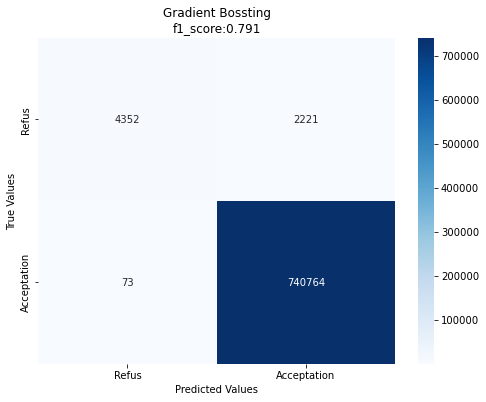

In [ ]:
plot_confusion_matrix(yTest,yPred,"Gradient Bossting")

In [ ]:
yPredScore = clf.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper, tper, thresholds = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'GradientBoosting', 'sampling':'none2', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
param_grid2 = {'max_depth': np.arange(7,15,1), 
              'num_leaves': np.arange(2,10,1) #,'feature_fraction': np.arange(0.1,1,0.1), 'subsample': np.arange(0.1,1,0.1)
              }

In [ ]:
model = lgb.LGBMClassifier(objective ='binary', n_estimators=15, feature_fraction=0.6,subsample=0.6 )
clf = GridSearchCV(estimator=model,
                   param_grid=param_grid2,
                   scoring=make_scorer(f1_score), 
                   cv= TimeSeriesSplit(5),n_jobs=-1)

clf.fit(XTrain.compute(),yTrain.compute())

clf.best_estimator_

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


LGBMClassifier(feature_fraction=0.6, max_depth=7, n_estimators=15, num_leaves=3,
               objective='binary', subsample=0.6)

Cette fois nous obtenons num_leaves = 10 et max_depth = 7. Construisons un permier modèle avec ces paramètres.

In [ ]:
yPred = clf.best_estimator_.predict(XTest)


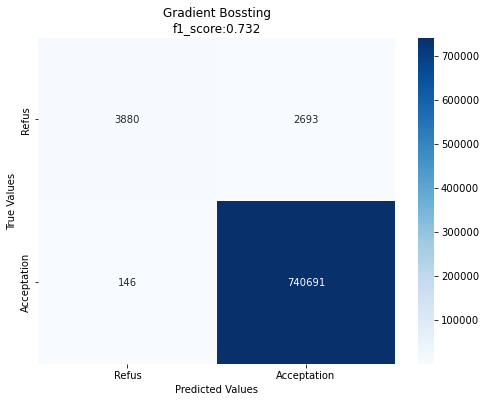

In [ ]:
plot_confusion_matrix(yTest,yPred,"Gradient Bossting")

In [ ]:
yPredScore = clf.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper1, tper1, thresholds1 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'GradientBoosting', 'sampling':'none', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
GraphFrame

,sampling,modele,fscore,auc
0,none,GradientBoosting,0.732145,0.931121
1,none2,GradientBoosting,0.791417,0.936595


In [ ]:
# Sauvegarde des résultats de l'analyse disciminante -> score_ADL

with open('score_GradientBoosting2', 'wb') as f1:
    pickle.dump(GraphFrame, f1)

##### IV.3.2.2 GB avec ré-échantillonnage

###### RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state=42)
pipelineGB = imbPipeline([('rus', rus),('gradB',lgb.LGBMClassifier(objective ='binary', n_estimators=9,
                            subsample=0.1,feature_fraction=0.3, max_depth=7,
                            num_leaves=10, min_gain_to_split=0.001))])
paramsGB = {
    'rus__sampling_strategy':[0.1,0.2,0.3],
}

tscv = TimeSeriesSplit(5)
gridsearchGB = sklearn_GridSearchCV(estimator=pipelineGB,param_grid=paramsGB,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchGB.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchGB.best_estimator_.predict(XTest)

print(gridsearchGB.best_params_)
print(gridsearchGB.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
{'rus__sampling_strategy': 0.2}
0.7419337187669608


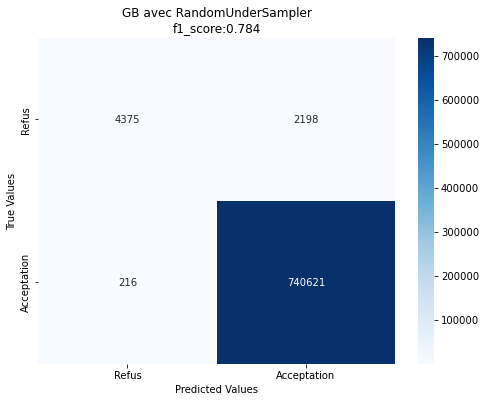

In [ ]:
plot_confusion_matrix(yTest,yPred,"GB avec RandomUnderSampler")

In [ ]:
yPredScore = gridsearchGB.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper2, tper2, thresholds2 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'GradientBoosting', 'sampling':'rus', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

###### RandomOverSampler

In [ ]:

ros = RandomOverSampler(random_state=42)
pipelineGB = imbPipeline([('ros', ros),('GB', lgb.LGBMClassifier(objective ='binary', n_estimators=9,
                            subsample=0.1,feature_fraction=0.3, max_depth=7,
                            num_leaves=10, min_gain_to_split=0.001))])
paramsGB = {
    'ros__sampling_strategy':[0.1,0.2,0.3],
}

tscv = TimeSeriesSplit(5)
gridsearchGB = sklearn_GridSearchCV(estimator=pipelineGB,param_grid=paramsGB,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchGB.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchGB.best_estimator_.predict(XTest)

print(gridsearchGB.best_params_)
print(gridsearchGB.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
{'ros__sampling_strategy': 0.2}
0.7434855702020579


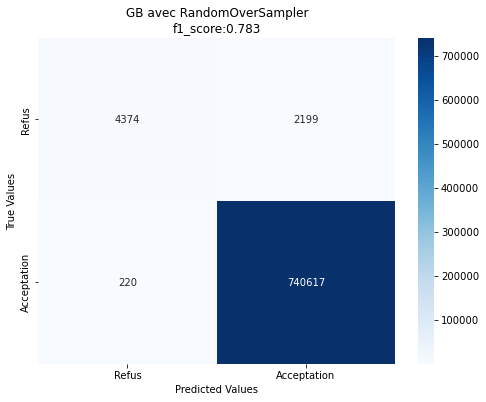

In [ ]:
plot_confusion_matrix(yTest,yPred,"GB avec RandomOverSampler")

In [ ]:
yPredScore = gridsearchGB.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper3, tper3, thresholds3 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'GradientBoosting', 'sampling':'ros', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

######  SMOTENC 

EXECUTION IMPOSSIBLE MEMOIRE SATUREE


In [ ]:
smotenc = SMOTENC(categorical_features=[17],n_jobs=-1,random_state=42,sampling_strategy=0.2)
pipelineGB = imbPipeline([('smotenc', smotenc),('GB', lgb.LGBMClassifier(objective ='binary', n_estimators=9,
                            subsample=0.1,feature_fraction=0.3, max_depth=7,
                            num_leaves=10, min_gain_to_split=0.001))])


#gridsearchGB = sklearn_GridSearchCV(estimator=pipelineGB,param_grid=paramsGB,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
pipelineGB.fit(XTrain.compute(),yTrain.compute())
yPred = pipelineGB.predict(XTest)


In [ ]:
plot_confusion_matrix(yTest,yPred,"GB avec SMOTENC")

In [ ]:
yPredScore = gridsearchGB.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper4, tper4, thresholds4 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'GradientBoosting', 'sampling':'SMOTENC', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
GraphFrame

,auc,sampling,fscore,modele
0,0.935719,rus,0.783769,GradientBoosting
1,0.936372,ros,0.783380,GradientBoosting


#### IV.3.3 Analyse discriminante linéaire

LDA est une est une technique couramment utilisée pour la réduction de la dimensionnalité et la classification. Pour la classification, elle consiste à trouver une combinaison linéaire de caractéristiques, qui sépare deux ou plusieurs classes de données. LDA dessine un hyperplan et projette les données sur cet hyperplan de manière à maximiser la séparation des deux catégories, en maximisant le rapport de la variance inter-groupes et la variance intra-groupe.


In [ ]:
# création d'un dataframe qui contiendra les résultats de nos meilleurs modèles pour les comparer à la fin
GraphFrame = pd.DataFrame(columns={'modele', 'sampling', 'auc', 'fscore'})

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV as sklearn_GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

##### IV.3.3.1 ADL sans ré-échantillonnage

###### 1er essai sans prétraitements

In [ ]:
# F1 score de la cross validation avec les paramètres par défaut et sans prétraitements

%%time 
tscv = TimeSeriesSplit(5)
print(cross_val_score(LinearDiscriminantAnalysis(), XTrain.compute(), yTrain.compute(), scoring = make_scorer(f1_score),cv=tscv).mean())

0.5912244051554403
Wall time: 45 s


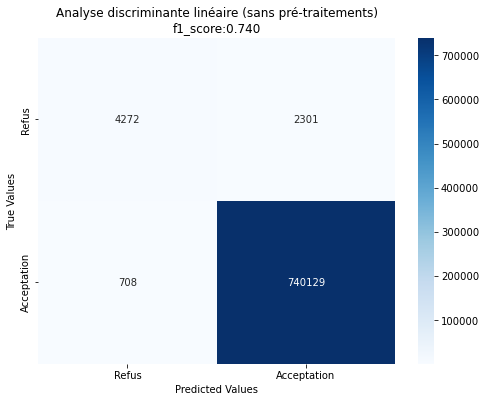

Wall time: 3min 3s


In [ ]:
%%time
clf = LinearDiscriminantAnalysis()
clf.fit(XTrain, yTrain)
yPred = clf.predict(XTest)
plot_confusion_matrix(yTest,yPred,"Analyse discriminante linéaire (sans pré-traitements)")

###### 2ème essai avec prétraitements

In [ ]:
%%time 

tscv = TimeSeriesSplit(5)
prep = preprocessing(XTrain,scale="y",onehot="y")
pipelineADL = Pipeline([('prep',prep),('lda', LinearDiscriminantAnalysis())])
print(cross_val_score(pipelineADL, XTrain.compute(), yTrain.compute(), scoring = make_scorer(f1_score),cv=tscv).mean())

0.7472890428036228
Wall time: 1min 18s


In [ ]:
%%time 
pipelineADL.fit(XTrain,yTrain)
yPred = pipelineADL.predict(XTest)

Wall time: 60 s


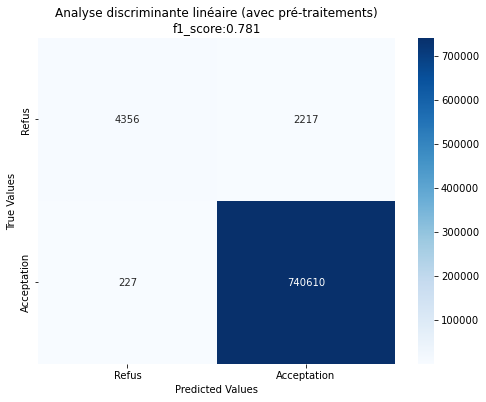

Wall time: 2min 20s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred,"Analyse discriminante linéaire (avec pré-traitements)")

In [ ]:
#Calcul des prédictions
yPredScore = pipelineADL.predict_proba(XTest)
prob = yPredScore[:, 1]
fper1, tper1, thresholds1 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'ADL', 'sampling':'none', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

Nous avons obtenu un meilleur f1 score avec les prétraitements, nous garderons ce modèle pour le comparer avec des méthodes de ré-échantillonage

##### IV.3.3.2 ADL avec ré-échantillonnage

Nous utiliserons les prétraitements dans cette partie

In [ ]:
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV as sklearn_GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

###### RandomUnderSampler

In [ ]:
%%time 

prep = preprocessing(XTrain,scale="y",onehot="y")
rus = RandomUnderSampler(random_state=42)
pipelineADL = imbPipeline([('rus', rus),('prep',prep),('lda', LinearDiscriminantAnalysis(solver='svd'))])
paramsADL = {
    'rus__sampling_strategy':[0.1,0.2,0.3],
}

tscv = TimeSeriesSplit(5)
gridsearchADL = sklearn_GridSearchCV(estimator=pipelineADL,param_grid=paramsADL,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchADL.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchADL.best_estimator_.predict(XTest)

print(gridsearchADL.best_params_)
print(gridsearchADL.best_score_)

{'rus__sampling_strategy': 0.1}
0.7212849278834255
Wall time: 1min 24s


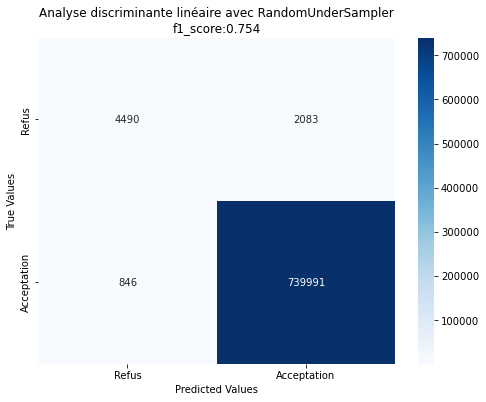

In [ ]:
plot_confusion_matrix(yTest,yPred,"Analyse discriminante linéaire avec RandomUnderSampler")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchADL.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper2, tper2, thresholds2 = roc_curve(yTest, prob)

In [ ]:
aucRus = roc_auc_score(yTest,prob)
f1Rus = f1_score(yTest, yPred,average='binary')
line = {'modele':'ADL', 'sampling':'RUS', 'auc':aucRus, 'fscore': f1Rus}
GraphFrame = GraphFrame.append(line, ignore_index=True)

###### RandomOverSampler

In [ ]:
%%time 

prep = preprocessing(XTrain,scale="y",onehot="y")
ros = RandomOverSampler(random_state=42)
pipelineADL = imbPipeline([('ros', ros),('prep',prep),('lda', LinearDiscriminantAnalysis(solver='svd'))])
paramsADL = {
    'ros__sampling_strategy':[0.1,0.2,0.3],
}

tscv = TimeSeriesSplit(5)
gridsearchADL = sklearn_GridSearchCV(estimator=pipelineADL,param_grid=paramsADL,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchADL.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchADL.best_estimator_.predict(XTest)
print(gridsearchADL.best_params_)
print(gridsearchADL.best_score_)

{'ros__sampling_strategy': 0.1}
0.7192378510828354
Wall time: 3min 42s


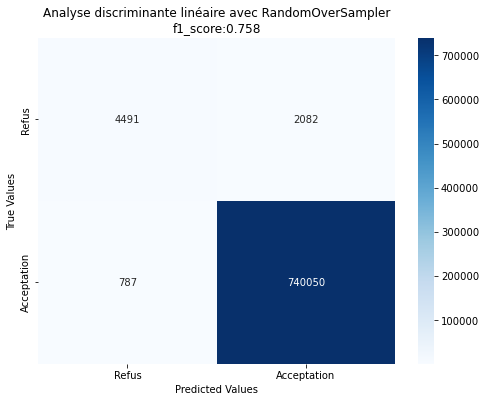

In [ ]:
plot_confusion_matrix(yTest,yPred,"Analyse discriminante linéaire avec RandomOverSampler")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchADL.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper3, tper3, thresholds3 = roc_curve(yTest, prob)

In [ ]:
aucRos = roc_auc_score(yTest,prob)
f1Ros = f1_score(yTest, yPred,average='binary')
line = {'modele':'ADL', 'sampling':'ROS', 'auc':aucRos, 'fscore': f1Ros}
GraphFrame = GraphFrame.append(line, ignore_index=True)

###### SMOTENC

In [ ]:
%%time 
smotenc = SMOTENC(categorical_features=[17],n_jobs=-1,random_state=42)
pipelineADL = imbPipeline([
                        ('prep1',preprocessing(XTrain,scale="y",onehot="n")),
                        ('smotenc', smotenc),
                        ('prep2', preprocessing(XTrain,scale="n",onehot="y")),
                        ('lda', LinearDiscriminantAnalysis(solver='svd'))])
paramsADL = {
    'smotenc__sampling_strategy':[0.1,0.2],
}

tscv = TimeSeriesSplit(5)
gridsearchADL = sklearn_GridSearchCV(estimator=pipelineADL,param_grid=paramsADL,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchADL.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchADL.best_estimator_.predict(XTest)
print(gridsearchADL.best_params_)
print(gridsearchADL.best_score_)

{'smotenc__sampling_strategy': 0.1}
0.7195120660880405
Wall time: 5min 43s


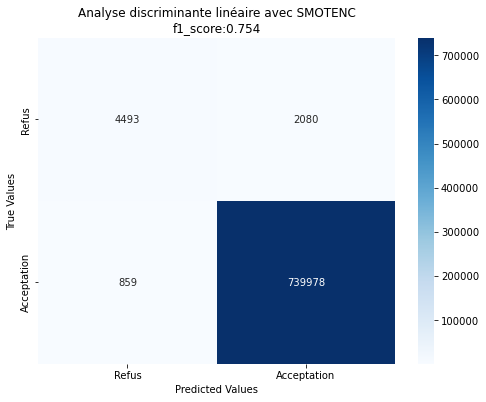

In [ ]:
plot_confusion_matrix(yTest,yPred,"Analyse discriminante linéaire avec SMOTENC")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchADL.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper4, tper4, thresholds4 = roc_curve(yTest, prob)

In [ ]:
aucSmotenc = roc_auc_score(yTest,prob)
f1Smotenc = f1_score(yTest, yPred,average='binary')
line = {'modele':'ADL', 'sampling':'SMOTENC', 'auc':aucSmotenc, 'fscore': f1Smotenc}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
GraphFrame

,sampling,fscore,modele,auc
0,none,0.780925,ADL,0.936955
1,RUS,0.754052,ADL,0.938078
2,ROS,0.757911,ADL,0.937677
3,SMOTENC,0.753543,ADL,0.937336


In [ ]:
# Sauvegarde des résultats de l'analyse disciminante -> score_ADL

#with open('score_ADL', 'wb') as f1:
#    pickle.dump(GraphFrame, f1)

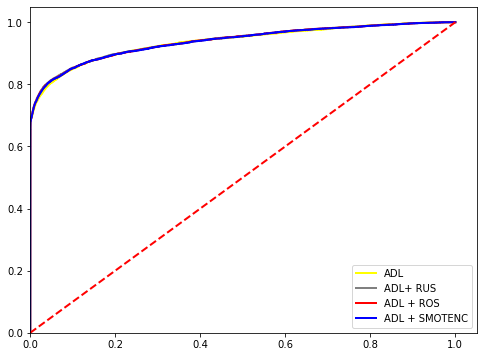

In [ ]:
lw=2
plt.plot(fper1, tper1, color='yellow', lw=lw, label='ADL' )
plt.plot(fper2, tper2, color = 'grey', lw=lw, label='ADL+ RUS')
plt.plot(fper3, tper3, color = 'red', lw=lw, label='ADL + ROS')
plt.plot(fper4, tper4, color = 'blue', lw=lw, label='ADL + SMOTENC')
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

Nous pouvons conclure que le modèle qui maximise le f1 score est l'analyse discriminante linéaire sans méthode de ré-échantillonage.
Les courbes ROC sont très semblables avec ou sans ré-échantillonage. 

#### IV.3.4 Regression Logistique

La régression logistique propose de tester un modèle de régression dont la variable dépendante est binaire et dont les variables indépendantes peuvent être continues ou catégorielles.  

La régression logistique s’apparente beaucoup à la régression linéaire où poids de chaque variable indépendante est représenté par un coefficient de régression.
Un modèle de régression logistique permet aussi de prédire la probabilité qu’un événement arrive à partir de l’optimisation des coefficients de régression.  

Lorsque la valeur prédite est supérieure à 0,5, l’événement est susceptible de se produire, alors que lorsque cette valeur est inférieure à 0,5, il ne l’est pas.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV as sklearn_GridSearchCV

In [ ]:
# création d'un dataframe qui contiendra les résultats de nos meilleurs modèles pour les comparer à la fin
GraphFrame = pd.DataFrame(columns={'modele', 'sampling', 'auc', 'fscore'})

##### IV.3.4.1 Regression logistique sans ré-échantillonnage

Nous avons tester ici avec le solveur lbfgs, il s'agit du seul qui a convergé rapidement et sans erreur

In [ ]:
%%time 

prep = preprocessing(XTrain,scale="y",onehot="y")
pipelineLR = Pipeline([('prep',prep),('lr', LogisticRegression(n_jobs=-1,solver='lbfgs',max_iter=1000))])
paramsLR = {
    'lr__penalty':['none','l2']
}

tscv = TimeSeriesSplit(5)
gridsearchLR = sklearn_GridSearchCV(estimator=pipelineLR,param_grid=paramsLR,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchLR.fit(XTrain.compute(),yTrain.compute())

Wall time: 5min 46s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB',
       'ScoringFP1', 'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB',
       'TauxIm...rtNumCheq', 'NbrMagasin3J', 'DiffDateTr1',
       'DiffDateTr2', 'DiffDateTr3', 'CA3TRetMtt', 'CA3TR'],
      dtype='object')),
                                                                        ('cat',
                                                            

In [ ]:
yPred = gridsearchLR.best_estimator_.predict(XTest)
print(gridsearchLR.best_params_)
print(gridsearchLR.best_score_)

{'lr__penalty': 'none'}
0.756726266180576


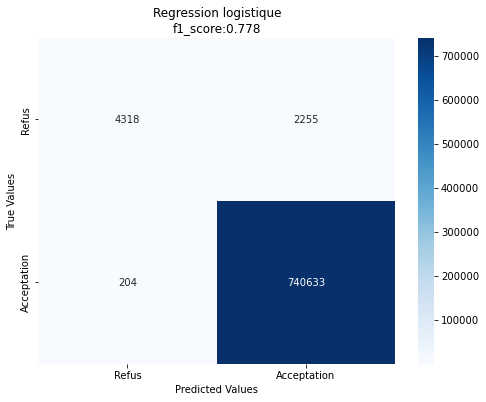

Wall time: 3min 15s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred,"Regression logistique")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchLR.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper1, tper1, thresholds1 = roc_curve(yTest, prob)

In [ ]:
auc = roc_auc_score(yTest,prob)
f1 = f1_score(yTest, yPred,average='binary')
line = {'modele':'LR', 'sampling':'none', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
line = {'modele':'LR', 'sampling':'none', 'auc':auc, 'fscore': f1}
GraphFrame = GraphFrame.append(line, ignore_index=True)

##### IV.3.4.2 Regression logistique avec ré-échantillonnage

In [ ]:
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV as sklearn_GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer

###### RandomUnderSampler

In [ ]:
%%time 

prep = preprocessing(XTrain,scale="y",onehot="y")
rus = RandomUnderSampler(random_state=42)
pipelineLR = imbPipeline([('rus', rus),
                           ('prep',prep),
                           ('lr', LogisticRegression(n_jobs=-1,solver='lbfgs',max_iter=1000))])
paramsLR = {
    'rus__sampling_strategy':[0.1,0.2,0.3],
}

tscv = TimeSeriesSplit(5)
gridsearchLR= sklearn_GridSearchCV(estimator=pipelineLR,param_grid=paramsLR,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchLR.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchLR.best_estimator_.predict(XTest)

print(gridsearchLR.best_params_)
print(gridsearchLR.best_score_)

{'rus__sampling_strategy': 0.1}
0.6251522382944581
Wall time: 1min 18s


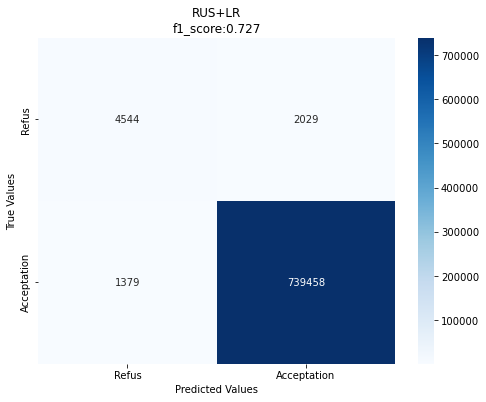

Wall time: 2min 48s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred,"RUS+LR")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchLR.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper2, tper2, thresholds2 = roc_curve(yTest, prob)

In [ ]:
aucRus = roc_auc_score(yTest,prob)
f1Rus = f1_score(yTest, yPred,average='binary')
line = {'modele':'LR', 'sampling':'RUS', 'auc':aucRus, 'fscore': f1Rus}
GraphFrame = GraphFrame.append(line, ignore_index=True)

###### RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
%%time 

prep = preprocessing(XTrain,scale="y",onehot="y")
ros = RandomOverSampler(random_state=42)
pipelineLR = imbPipeline([('ros', ros),
                           ('prep',prep),
                           ('lr', LogisticRegression(n_jobs=-1,solver='lbfgs',max_iter=1000))])
paramsLR = {
    'ros__sampling_strategy':[0.1,0.2,0.3],
}

tscv = TimeSeriesSplit(5)
gridsearchLR= sklearn_GridSearchCV(estimator=pipelineLR,param_grid=paramsLR,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchLR.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchLR.best_estimator_.predict(XTest)

print(gridsearchLR.best_params_)
print(gridsearchLR.best_score_)

{'ros__sampling_strategy': 0.1}
0.6254713769958083
Wall time: 8min 1s


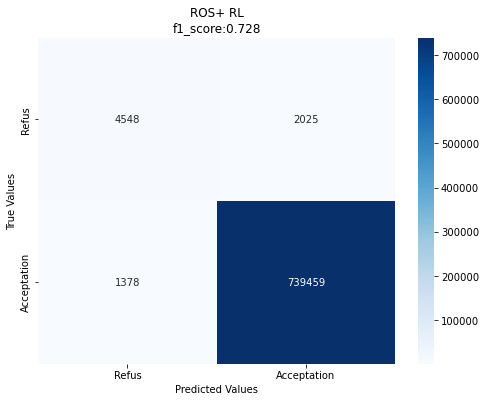

Wall time: 3min 48s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred,"ROS+ RL")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchLR.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper3, tper3, thresholds3 = roc_curve(yTest, prob)

In [ ]:
aucRos = roc_auc_score(yTest,prob)
f1Ros = f1_score(yTest, yPred,average='binary')
line = {'modele':'LR', 'sampling':'ROS', 'auc':aucRos, 'fscore': f1Ros}
GraphFrame = GraphFrame.append(line, ignore_index=True)

###### SMOTENC

In [ ]:
%%time 
smotenc = SMOTENC(categorical_features=[17],n_jobs=-1,random_state=42)
pipelineLR = imbPipeline(
    [('prep1',preprocessing(XTrain,scale="y",onehot="n")),
     ('smotenc', smotenc),
     ('prep2', preprocessing(XTrain,scale="n",onehot="y")),
     ('LR', LogisticRegression(n_jobs=-1,solver='lbfgs',max_iter=1000))])

paramsLR = {
    'smotenc__sampling_strategy':[0.1,0.2],
}

tscv = TimeSeriesSplit(5)
gridsearchLR = sklearn_GridSearchCV(estimator=pipelineLR,param_grid=paramsLR,n_jobs=-1,scoring=make_scorer(f1_score),cv=tscv)
gridsearchLR.fit(XTrain.compute(),yTrain.compute())
yPred = gridsearchLR.best_estimator_.predict(XTest)

Wall time: 9min 26s


In [ ]:
print(gridsearchLR.best_params_)
print(gridsearchLR.best_score_)

{'smotenc__sampling_strategy': 0.1}
0.6279168459772334


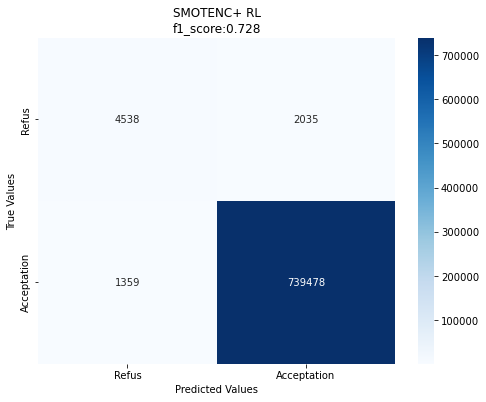

Wall time: 3min 16s


In [ ]:
%%time
plot_confusion_matrix(yTest,yPred,"SMOTENC+ RL")

In [ ]:
#Calcul des prédictions
yPredScore = gridsearchLR.best_estimator_.predict_proba(XTest)
prob = yPredScore[:, 1]
fper4, tper4, thresholds3 = roc_curve(yTest, prob)

In [ ]:
aucSmotenc = roc_auc_score(yTest,prob)
f1Smotenc = f1_score(yTest, yPred,average='binary')
line = {'modele':'LR', 'sampling':'SMOTENC', 'auc':aucSmotenc, 'fscore': f1Smotenc}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
# Sauvegarde des résultats de la régression logistique 
#with open('score_LR', 'wb') as f1:
#    pickle.dump(GraphFrame, f1)

In [ ]:
GraphFrame

,sampling,modele,fscore,auc
0,none,GradientBoosting,0.732145,0.931121
1,none2,GradientBoosting,0.791417,0.936595
2,none,LR,0.778369,0.936743
3,none,LR,0.778369,0.936743
4,RUS,LR,0.727273,0.938892
5,ROS,LR,0.727738,0.938922
6,SMOTENC,LR,0.727827,0.938620


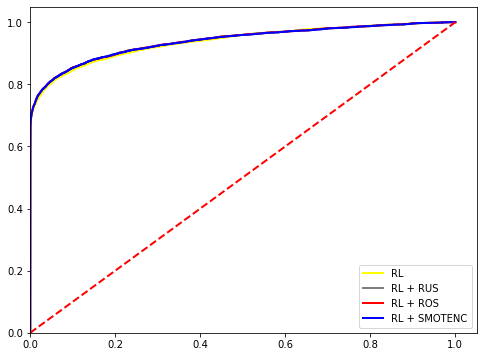

In [ ]:
lw=2
plt.plot(fper1, tper1, color='yellow', lw=lw, label='RL' )
plt.plot(fper2, tper2, color = 'grey', lw=lw, label='RL + RUS')
plt.plot(fper3, tper3, color = 'red', lw=lw, label='RL + ROS')
plt.plot(fper4, tper4, color = 'blue', lw=lw, label='RL + SMOTENC')
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

### IV.4 Méthodes non supervisées

#### IV.4.1 KMEANS


L'algorithme de clustering K-means calcule les centroïdes et les répète jusqu'à ce que le centroïde optimal soit trouvé. Le nombre de clusters trouvés à partir des données par la méthode de la silhouette par exemple permettant d’optimiser ce paramêtre.



In [ ]:
kmeans = cluster.KMeans()

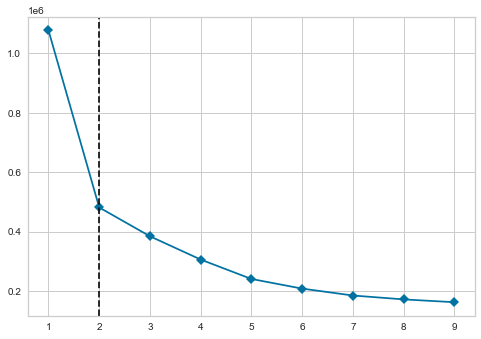

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
coude = KElbowVisualizer(kmeans,k=(1,10),metric="distortion",timings=False)
fit_coude = coude.fit(XTrain_Scale)

D'après le critère du coude le nombre de cluster le plus optimisé serait de deux cluster dans ce jeu de données, nous allons donc faire tourner le kmens sur ce nombre. On confrontera ensuite les classes prédites à nos données pour voir si les transactions frauduleuses sont similaires à une de nos classes.


In [ ]:
prep = preprocessing(XTrain,scale="y",onehot="y")
pipelineKmeans = Pipeline([('prep',prep),('kmeans', cluster.KMeans(n_clusters=2))])

In [ ]:
pipelineKmeans.fit(XTrain)

Pipeline(steps=[('prep',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB',
       'ScoringFP1', 'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB',
       'TauxImpNB_CPM', 'EcartNumCheq', 'NbrMagasin3J', 'DiffDateTr1',
       'DiffDateTr2', 'DiffDateTr3', 'CA3TRetMtt', 'CA3TR'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   DummyEncoder(drop_first=True))]),
                                                  Index(['CodeDecision'], dtype='object'))])),
                ('kmeans',

In [ ]:
yPred = pipelineKmeans.predict(XTest)

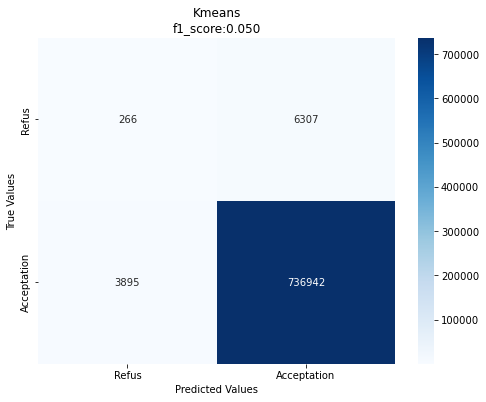

In [ ]:
plot_confusion_matrix(yTest,yPred,"Kmeans")

On peut conclure que le kmeans n'est pas approprié sur ces données. Les fraudes et les non-fraudes ne se distinguent donc pas particulièrement au travers de cet algorithmes non-supervisé.

####IV.4.2 IsolationForest

Tout point de données/observation qui s'écarte de manière significative des autres observations est appelé une anomalie/une valeur aberrante. La détection d'anomalies est importante et trouve son application dans divers domaines comme justement la détection de transactions bancaires frauduleuses.  


L’IsolationForest est une méthode non supervisée basée sur la construction d’arbres de décision qui permet de détecter des valeurs atypiques dans un dataset.
Les IsolationForests ont été construites sur la base du fait que les anomalies sont les points de données qui sont peu nombreux et différents.  

Dans une forêt d'isolement, les données sous-échantillonnées au hasard sont traitées dans une structure arborescente basée sur des caractéristiques sélectionnées au hasard. Les échantillons qui se retrouvent plus profondément dans l'arbre sont moins susceptibles d'être des anomalies car ils ont nécessité plus de coupes pour les isoler. De même, les échantillons qui se retrouvent dans des branches plus courtes indiquent des anomalies car il était plus facile pour l'arbre de les séparer des autres observations.

Par défaut la forêt d'isolement est constituée de 100 arbres. Nous avons indiqué la valeur 0.00645 pour le paramètre *contamination* qui correspond à la proportion de valeurs aberrantes dans l'ensemble de données, c'est à dire dans notre cas le pourcentage de fraude dans le jeu de données. 

In [ ]:
isf = IsolationForest(random_state=42,n_jobs=-1,contamination=0.00645)

In [ ]:
isf.fit(XTrain)
yPred = isf.predict(XTest)

C:\Users\rodud\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
Counter(yPred)

Counter({1: 743919, -1: 3491})

In [ ]:
# Les valeurs retournées sont -1 pour les outliers et 1 pour les valeurs normales.
# Nous allons recoder ces valeurs pour faire nos prédictions et évaler les performances.
yPred = np.where(yPred==1,0,yPred)
yPred = np.where(yPred==-1,1,yPred)
Counter(yPred)

Counter({0: 743919, 1: 3491})

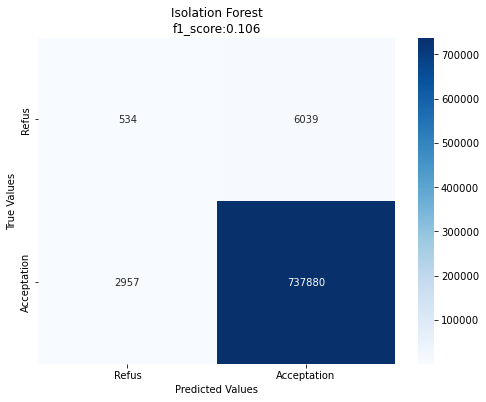

In [ ]:
plot_confusion_matrix(yTest,yPred,"Isolation Forest")

On constate que le f1 score est assez faible et que donc l'algorithme a du mal à distinguer les transactions frauduleuses comme étant des outliers.

In [ ]:
# création d'un dataframe qui contiendra les résultats de nos meilleurs modèles pour les comparer à la fin
GraphFrame = pd.DataFrame(columns={'modele', 'sampling', 'auc', 'fscore'})

In [ ]:
f1Isolation_forest  = f1_score(yTest, yPred,average='binary')
line = {'modele':'Isolation_forest', 'sampling':None, 'auc':None, 'fscore': f1Isolation_forest}
GraphFrame = GraphFrame.append(line, ignore_index=True)

In [ ]:
GraphFrame

,sampling,fscore,modele,auc
0,None,0.106121,Isolation_forest,None


#### IV.4.3 AUTO ENCODERS: détection d'anomalies


Les autoencoders sont un type de réseau de neurones particulier; ils peuvent être définis comme un perceptron à une ou plusieurs couches cachées où les entrées et les sorties sont identiques. On dit qu'ils sont self-supervised c'est à dire auto-suppervisés. En sortie de la couche centrale, nous disposons d’une représentation des données dans un espace de dimension réduite.

On cherche à obtenir une forme de nettoyage des données non frauduleuses où seules les informations utiles sont conservées. Si on observe de forts écarts, alors il y a peut-être problèmes (points atypiques) ou bien des caractéristiques particulières, spécifiques. C’est pourquoi cette technique est utilisée aussi bien pour la détection d’anomalies que dans un contexte déséquilibré comme c’est le cas ici.

Pour résumer, voici les étapes de base de la détection d’anomalies à l’aide d’un auto-encodeur : 

-Entraîner un auto-encodeur sur des données normales (sans anomalies)

-Prendre un nouveau point de données et essayez de le reconstruire en utilisant l’auto-encodeur.

-Si l’erreur (erreur de reconstruction) pour le nouveau point de données est supérieure à un certain seuil, nous considérons l’exemple comme une anomalie.

Appliquons cette méthode à nos données:

Nous construisons un échantillon de validation : 

In [ ]:
ColsToRemove2 = ["ZIBZIN","IDAvisAutorisationCheque","DateTransaction","Heure"]
ColsToKeep2 = [col for col in data.columns if col not in ColsToRemove2]


app = data[data['DateTransaction'] < '2017-09-01'][ColsToKeep2]
test= data[data['DateTransaction'] >= "2017-09-01"][ColsToKeep2]

Nous construisons un échantillon de validation puis nous séparons notre échantillon en 2 : les données 'normales' c'est à dire non frauduleuses d'une part, et les 'anomalies' d'autre part c'est à dire les données frauduleuses. On entrainera le modèle uniquement avec les données 'normales'.

In [ ]:
df_app, df_valid = train_test_split(app, test_size=DATA_SPLIT_PCT, random_state=SEED)

Apprentissage avec y==0 : *Normal*
et avec y==1 : "Frauduleux"

In [ ]:
train_0 = df_app.loc[df_app['FlagImpaye'] == 0]
Xtrain_0 = train_0.drop(['FlagImpaye'], axis=1)

In [ ]:
train_1 = df_app.loc[df_app['FlagImpaye'] == 1]
Xtrain_1 = train_1.drop(['FlagImpaye'], axis=1)

Validation avec y==0 : *Normal*
et avec y==1 : "Frauduleux"

In [ ]:
valid_0 = df_valid.loc[df_valid['FlagImpaye'] == 0]
Xvalid_0 = valid_0.drop(['FlagImpaye'], axis=1)

In [ ]:
valid_1 = df_valid.loc[df_valid['FlagImpaye'] == 1]
Xvalid_1 = valid_1.drop(['FlagImpaye'], axis=1)

Test avec y==0 : *Normal*
et avec y==1 : "Frauduleux"

In [ ]:
test_0 = test.loc[test['FlagImpaye'] == 0]
Xtest_0 = test_0.drop(['FlagImpaye'], axis=1)

In [ ]:
test_1 = test.loc[test['FlagImpaye'] == 1]
Xtest_1 = test_1.drop(['FlagImpaye'], axis=1)

On standardise sur les données d'apprentissage et on procède au codage disjonctif de CodeDecision.

In [ ]:
from dask_ml.preprocessing import StandardScaler, DummyEncoder
from dask_ml.compose import ColumnTransformer

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline


def preprocessing(XTrain,scale="y",onehot="n"):

    numerical_features = XTrain.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = XTrain.select_dtypes(include=['category']).columns

    # Standardisation
    numerical_pipeline = Pipeline([('scaler',StandardScaler())])

    # Codage disjonctif
    categorical_pipeline = Pipeline([('onehot',DummyEncoder(drop_first=True))]) 

    if ((scale =="y") and (onehot=="y")):
      preprocessor = ColumnTransformer(
          transformers = [
              ('num',numerical_pipeline,numerical_features),
              ('cat',categorical_pipeline,categorical_features)
          ],n_jobs=-1
      )
    elif  ((scale =="y") and (onehot=="n")):
      preprocessor = ColumnTransformer(
          transformers =[
              ('num',numerical_pipeline,numerical_features)
          ],
          remainder='passthrough',
          n_jobs=-1
      )

    prep = Pipeline([('preprocessor',preprocessor)])
    
    return prep


In [ ]:
prep_app = preprocessing(Xtrain_0.head(), onehot="y")

Xtrain_0_sca = prep_app.fit_transform(Xtrain_0.compute())

Xvalid_0_sca = prep_app.transform(Xvalid_0.compute())
Xvalid_sca = prep_app.transform(df_valid.drop(['FlagImpaye'], axis = 1).compute())

Xtest_0_sca = prep_app.transform(Xtest_0.compute())
Xtest_sca = prep_app.transform(test.drop(['FlagImpaye'], axis = 1).compute())


Nous avons créé ce premier modèle avec en entrée nos variables (20) et 4 couches cachées de 13, 5, 5, et 13 neurones. On fit ensuite le modèle sur les données d'apprentissage. Les données de validation nous permettent de suivre l'apprentissage du modèle.


In [ ]:
nb_epoch = 50
batch_size = 500
input_dim = Xtrain_0_sca.shape[1] #num of predictor variables, 
encoding_dim = 13
hidden_dim = 5
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

In [ ]:
autoencoder.compile(metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],
                    loss='mean_squared_error',
                    optimizer='adam')


In [ ]:
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                save_best_only=True,
                verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(Xtrain_0_sca, Xtrain_0_sca,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(Xvalid_0_sca, Xvalid_0_sca),
                    verbose=1,
                    callbacks=[cp, tb]).history

On effectue des prédictions toujours sur l'échantillon de validation afin de trouver le meilleur seuil pour discriminer nos 'anomalies'

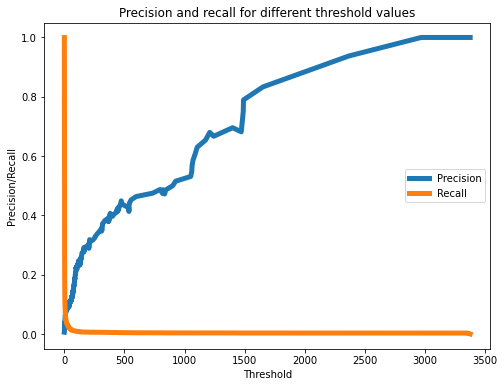

In [ ]:
valid_x_predictions = autoencoder.predict(Xvalid_sca)
mse = np.mean(np.power(Xvalid_sca - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['FlagImpaye']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

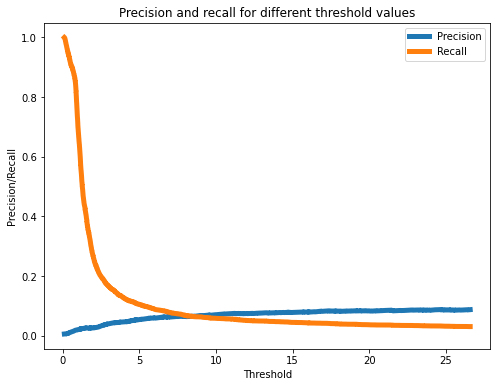

In [ ]:
plt.plot(threshold_rt[0:745000], precision_rt[1:745001], label="Precision",linewidth=5)
plt.plot(threshold_rt[0:745000], recall_rt[1:745001], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

On choisit un seuil de 4 et on calcule les scores de reconstruction sur l'échantillon test:

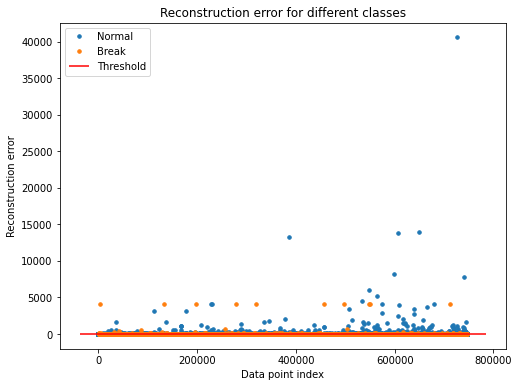

In [ ]:
test_x_predictions = autoencoder.predict(Xtest_sca)
mse = np.mean(np.power(Xtest_sca - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test['FlagImpaye']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Le graphique ci - dessus nous montre les erreurs de reconstruction ainsi que le seuil choisi selon la classe de l'individu.

En fonction de ces scores, on effectue maintenant les prédictions des classes des individus. Voici la matrice de confusion obtenue :


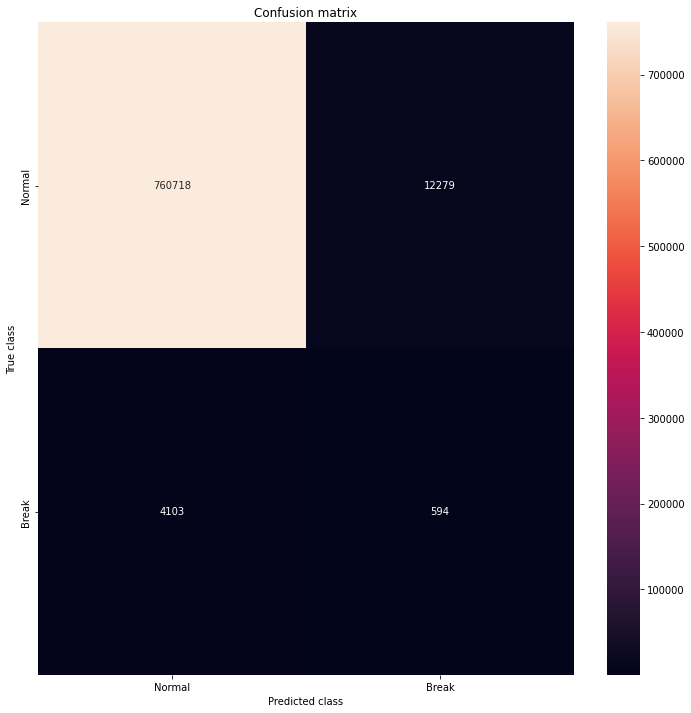

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Enfin, voici la courbe ROC ainsi que l'AUC correspondate de notre modèle:

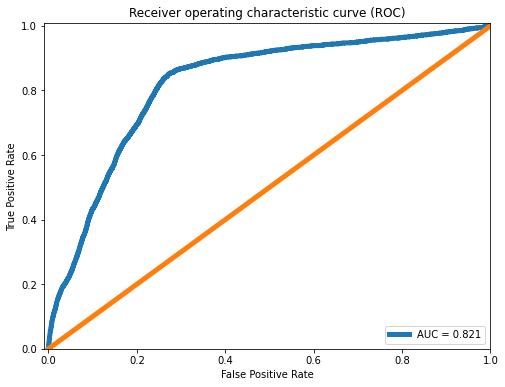

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
F1score_autoenc= f1_score(error_df.True_class, pred_y)
print(F1score_autoenc)

Le f1 score de ce modèle est très bas (0.01) mais l’AUC  étant correcte on peut supposer que la détermination d'un meilleur seuil pourrait fournir de meilleurs résultats. 

De plus, le nombre de neurones et de couches cachées  restent assez arbitraires et nous pourrions effectuer d'autres tests afin de les optimiser. 

Pour aller plus loin, nous avons construit un second modèle, cette fois ci avec davantage de couches cachées.  


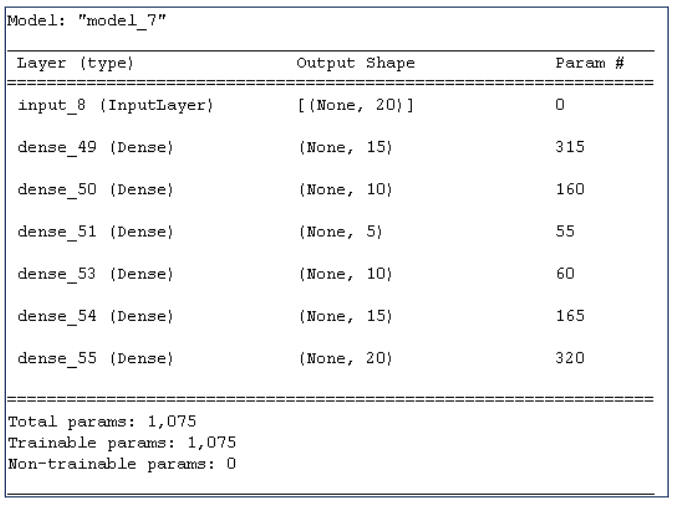

Cette fois, nous avons essayé de trouver un meilleur seuil. Pour cela nous avons utilisé la fonction ‘roc_curve’ de sklearn puis retrouvé le seuil qui maximise la différence entre le taux de vrais positifs et le taux de faux positifs à partir de l’échantillon de validation.

In [ ]:
fpr, tpr, threshold = roc_curve(error_df.True_class, error_df.Reconstruction_error)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(optimal_threshold)

Cette méthode s’est avérée, pour ce modèle, très peu efficace. 
Toutefois, nous sommes arrivés à obtenir un F1 score légèrement meilleur de 0.22 avec un seuil fixé à 0.5.

Pour aller encore plus loin, nous nous sommes éloignés de l’architecture ‘classique’ des auto encoder et nous avons augmenté le nombre de neurones par couche cachée.
Voici une représentation du réseau de neurone utilisé :


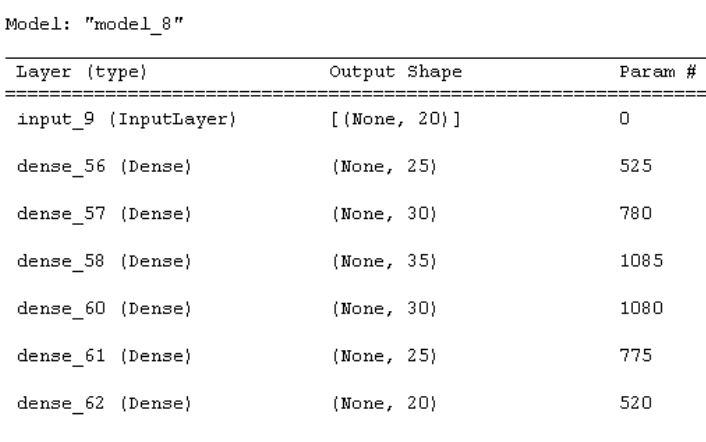

Avec la même méthode, le seuil trouvé était 0.031935732975977335

Ci-dessous la matrice de confusion sur l'échantillon test avec ce seuil : 


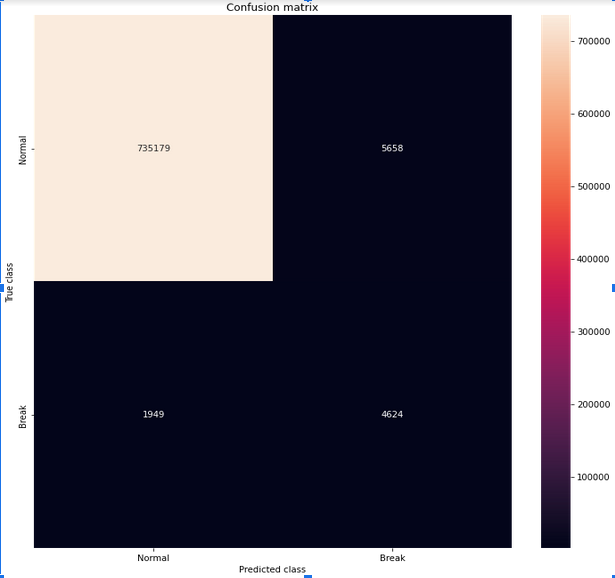

Ci-dessous la courbe ROC et l’AUC:


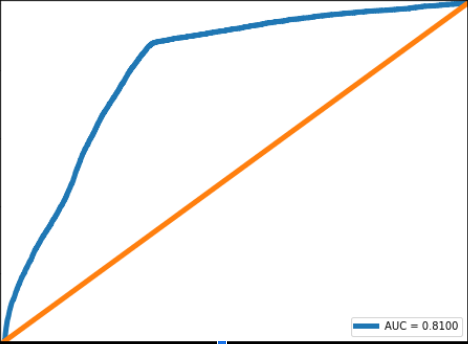

Le f1 score était de 0.5487 c’est-à-dire meilleur que tout ce que nous avions trouvé avec les auto-encoder précédemment. Ce résultat est encourageant et il serait judicieux de continuer à augmenter le nombre de neurones dans les couches cachées.

Pour conclure sur les autoencoders, c’est un type de modèle intéressant mais qui reste lourd en temps de calcul puisqu’il nécessite un nombre important de neurones afin d’être suffisamment précis.

Malgré tout, ce type de modèle est globalement intéressant puisqu'il se 'spécialise' dans la reconnaissance d 'anomalies/de fraudes. Nous pourrions par ailleurs nous intéresser au One Class SVM qui fonctionne sur le même principe et permet de délimiter les individus dans des espaces non linéaires.


##  V. Comparasion des modèles

In [ ]:
with open('score_GradientBoosting', 'rb') as f:
  score_GB = pickle.load(f)

In [ ]:
score_GB

,sampling,modele,fscore,auc
1,none,GradientBoosting,0.791417,0.936595


In [ ]:
#Harmonisation du DataFrame 

score_GB2['sampling'] = score_GB2['sampling'].replace(['rus'], 'RUS')
score_GB2['sampling'] = score_GB2['sampling'].replace(['ros'], 'ROS')
score_GB['sampling'] = score_GB['sampling'].replace(['none2'], 'none')



In [ ]:
with open('score_GradientBoosting2', 'rb') as f:
  score_GB2 = pickle.load(f)

In [ ]:
score_GB2

,auc,sampling,fscore,modele
0,0.935719,RUS,0.783769,GradientBoosting
1,0.936372,ROS,0.783380,GradientBoosting


In [ ]:
with open('score_ADL', 'rb') as f:
  score_ADL = pickle.load(f)

In [ ]:
score_ADL

,sampling,fscore,modele,auc
0,none,0.780925,ADL,0.936955
1,RUS,0.754052,ADL,0.938078
2,ROS,0.757911,ADL,0.937677
3,SMOTENC,0.753543,ADL,0.937336


In [ ]:
with open('score_LR', 'rb') as f:
  score_LR = pickle.load(f)

In [ ]:
score_LR

,auc,sampling,modele,fscore
1,0.936743,none,LR,0.778369
2,0.938892,RUS,LR,0.727273
3,0.938921,ROS,LR,0.727738
4,0.938620,SMOTENC,LR,0.727827


In [ ]:
with open('score_RF', 'rb') as f:
  score_RF = pickle.load(f)

In [ ]:
score_RF

,sampling,fscore,modele,auc
0,none,0.795356,Random Forest,0.903020
1,RUS,0.724408,Random Forest,0.931885
2,ROS,0.789842,Random Forest,0.905601
3,SMOTENC,0.775149,Random Forest,0.919038


In [ ]:
metrics = pd.concat([score_ADL,score_LR,score_RF,score_GB,score_GB2],axis=0)
metrics

,sampling,fscore,modele,auc
0,none,0.780925,ADL,0.936955
1,RUS,0.754052,ADL,0.938078
2,ROS,0.757911,ADL,0.937677
3,SMOTENC,0.753543,ADL,0.937336
1,none,0.778369,LR,0.936743
2,RUS,0.727273,LR,0.938892
3,ROS,0.727738,LR,0.938921
4,SMOTENC,0.727827,LR,0.938620
0,none,0.795356,Random Forest,0.903020
1,RUS,0.724408,Random Forest,0.931885


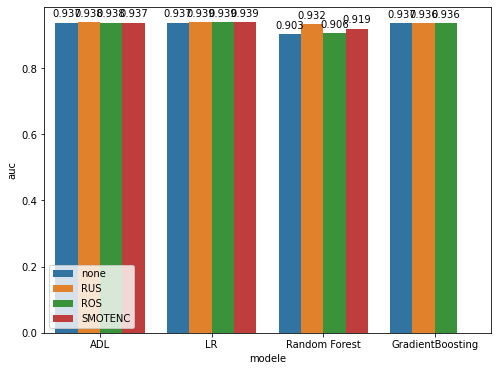

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
graph = sns.barplot(x = 'modele', y= 'auc', hue = 'sampling', data = metrics)
plt.legend(loc='lower left')
for p in graph.patches:
    graph.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

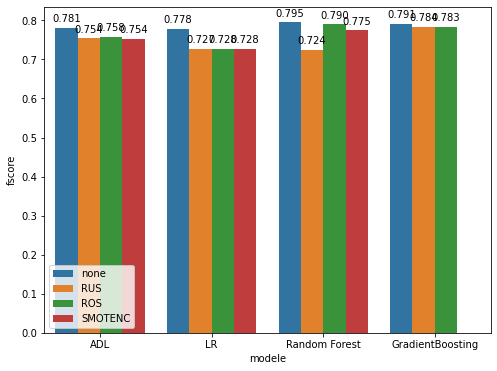

In [ ]:
graph = sns.barplot(x = 'modele', y= 'fscore', hue = 'sampling', data = metrics)
plt.legend(loc='lower left')
for p in graph.patches:
    graph.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Pour conclure les modèles qui ont fournissent les meilleures résultats sont Random Forest et GradientBoosting sans aucune méthode d'over ou under sampling.
Plus globalement les meilleures méthodes pour la détection de fraude dans un contexte désiquilibré sont des méthodes supervisé.

On remarque également que les algortihmes de ré-échantillonnage que nous avons testés n'ont pas permis d'améliorer les performences des algorithmes.
Le F1 score comme mesure de performences est très pénalisante puisqu'elle dépend énormément des mauvaises classifications.

Pour aller plus loin, nous aurions pu utiliser des une ACM afin de réduire le nombres de descripteurs et ainsi avoir des résulats plus pertinents.


# Bilan du projet

Pour finir, ce projet nous a permis d'approfondir nos compétences en apprentissage supervisé et non supervisé en contexte déséquilibré, ainsi que  nos connaissances en matière de machine learning. 
Il aura été l'occasion de développer de réelles aptitudes en gestion de projet (répartition de tâches, gestion du temps) et donc d'appréhender la réalisation d'un projet au sein d'une équipe. Ces aspects seront réellement utiles dans le monde professionnel. 